# クラス分類学習モデルの作成、予測の実行

In [1]:
import os
import random

# basic DS libraries
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

# plot libraries
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from seaborn_analyzer import classplot
import graphviz
import pydotplus
from IPython.display import Image
from six import StringIO

%matplotlib inline

# プログレスバー
from tqdm import tqdm

# 機械学習モデル
from sklearn.linear_model import LogisticRegression  # ロジスティック回帰
from sklearn.neighbors import KNeighborsClassifier  # K近傍法
from sklearn.svm import SVC  # サポートベクターマシン
from sklearn.tree import DecisionTreeClassifier, export_graphviz  # 決定木
from sklearn.ensemble import RandomForestClassifier  # ランダムフォレスト
from sklearn.ensemble import AdaBoostClassifier  # AdaBoost
from sklearn.naive_bayes import GaussianNB  # ナイーブ・ベイズ
from sklearn.decomposition import LatentDirichletAllocation as LDA  # 線形判別分析
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA  # 二次判別分析

# データセット分割・評価検証
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# config python file
import config

# 最大表示列数の指定（ここでは50列を指定）
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)

# ファイル保存関数（dirがなければ生成する）
def make_dir(dir_name: str):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)


# seedの固定
def fix_seed(seed: int):
    # random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)


# 再現性をもたせるためのseed固定
SEED = config.SEED
fix_seed(SEED)

# 2値分類モデルの作成・実行

2値分類モデルを作成、実行し、クラス分類に有用な特徴量を見つける  
決定木以外にも、基本的な2値分類を実施できるモデルを採用し、各モデル間で比較していく。  
精度は重視しないが、accuracyよりもf1スコアを重視する。  
目的変数に偏りがある（不均衡データ、1（5年後以内に死亡）<0（5年語以内に生存））ので、**サンプリング方法を要検討**

In [43]:
df_MB_RFS_status_dropped = pd.read_pickle(
    config.INTERIM_PICKLE_PREPROCESSED_DIR
    + "/2.0.4-df_MB_RFS_status_dropped.pkl"
)
df_MB_RFS_status_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1877 entries, 1 to 1979
Data columns (total 71 columns):
 #   Column                                                          Non-Null Count  Dtype  
---  ------                                                          --------------  -----  
 0   LYMPH_NODES_EXAMINED_POSITIVE                                   1877 non-null   float64
 1   NPI                                                             1877 non-null   float64
 2   CELLULARITY                                                     1877 non-null   float64
 3   CHEMOTHERAPY                                                    1877 non-null   object 
 4   ER_IHC                                                          1877 non-null   float64
 5   HER2_SNP6                                                       1877 non-null   float64
 6   HORMONE_THERAPY                                                 1877 non-null   object 
 7   INFERRED_MENOPAUSAL_STATE                          

In [23]:
df_MB_RFS_status_dropped.isnull().sum()

LYMPH_NODES_EXAMINED_POSITIVE    0
NPI                              0
CELLULARITY                      0
CHEMOTHERAPY                     0
ER_IHC                           0
                                ..
ONCOTREE_CODE_ILC                0
ONCOTREE_CODE_IMMC               0
ONCOTREE_CODE_MBC                0
ONCOTREE_CODE_MDLC               0
ONCOTREE_CODE_PBS                0
Length: 71, dtype: int64

In [24]:
print(df_MB_RFS_status_dropped.RFS_STATUS.value_counts())

print(
    "データセット全体に占める再発のデータの割合： ",
    df_MB_RFS_status_dropped[
        df_MB_RFS_status_dropped.RFS_STATUS == True
    ].shape[0]
    / df_MB_RFS_status_dropped.shape[0],
)

False    1106
True      771
Name: RFS_STATUS, dtype: int64
データセット全体に占める再発のデータの割合：  0.41076185402237614


# 学習データ分割

1. X（説明変数）とy（目的変数）に分割(y=df['target'])
2. train_test_splitによる基本的なデータ分割（train:test=75%:25%）※層化検証など他の分割手法は後で実施  

In [25]:
# Xとyに分割
X = df_MB_RFS_status_dropped.drop("RFS_STATUS", axis=1)
y = df_MB_RFS_status_dropped["RFS_STATUS"]
display(X.tail(), y.tail(), y.value_counts())

,LYMPH_NODES_EXAMINED_POSITIVE,NPI,CELLULARITY,CHEMOTHERAPY,ER_IHC,HER2_SNP6,HORMONE_THERAPY,INFERRED_MENOPAUSAL_STATE,AGE_AT_DIAGNOSIS,RADIO_THERAPY,ER_STATUS,HER2_STATUS,GRADE,PR_STATUS,TUMOR_SIZE,TUMOR_STAGE,TMB_NONSYNONYMOUS,COHORT_2.0,COHORT_3.0,COHORT_4.0,COHORT_5.0,INTCLUST_10,INTCLUST_2,INTCLUST_3,INTCLUST_4ER+,...,HISTOLOGICAL_SUBTYPE_Metaplastic,HISTOLOGICAL_SUBTYPE_Mixed,HISTOLOGICAL_SUBTYPE_Mucinous,HISTOLOGICAL_SUBTYPE_Other,HISTOLOGICAL_SUBTYPE_Tubular/ cribriform,HISTOLOGICAL_SUBTYPE_nan,BREAST_SURGERY_MASTECTOMY,BREAST_SURGERY_nan,LATERALITY_Right,LATERALITY_nan,CANCER_TYPE_Breast Sarcoma,CANCER_TYPE_DETAILED_Breast Angiosarcoma,CANCER_TYPE_DETAILED_Breast Invasive Ductal Carcinoma,CANCER_TYPE_DETAILED_Breast Invasive Lobular Carcinoma,CANCER_TYPE_DETAILED_Breast Invasive Mixed Mucinous Carcinoma,CANCER_TYPE_DETAILED_Breast Mixed Ductal and Lobular Carcinoma,CANCER_TYPE_DETAILED_Invasive Breast Carcinoma,CANCER_TYPE_DETAILED_Metaplastic Breast Cancer,ONCOTREE_CODE_BREAST,ONCOTREE_CODE_IDC,ONCOTREE_CODE_ILC,ONCOTREE_CODE_IMMC,ONCOTREE_CODE_MBC,ONCOTREE_CODE_MDLC,ONCOTREE_CODE_PBS
1975,1.0,5.05,3.0,False,1.0,2.0,True,-1.0,43.10,True,1,-1.0,3.0,1.0,25.0,2.0,5.230071,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
1976,1.0,5.04,3.0,False,1.0,3.0,False,-1.0,42.88,True,1,1.0,3.0,-1.0,20.0,2.0,7.845106,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
1977,45.0,6.05,3.0,False,1.0,2.0,True,1.0,62.90,True,1,-1.0,3.0,1.0,25.0,2.0,5.230071,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
1978,12.0,5.05,2.0,False,1.0,2.0,True,1.0,61.16,False,1,-1.0,2.0,1.0,25.0,2.0,19.612766,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
1979,1.0,5.04,3.0,False,1.0,2.0,True,1.0,60.02,True,1,-1.0,3.0,-1.0,20.0,2.0,3.922553,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0


1975    False
1976     True
1977     True
1978    False
1979    False
Name: RFS_STATUS, dtype: bool

False    1106
True      771
Name: RFS_STATUS, dtype: int64

In [26]:
# trainとtestに分割

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=config.SEED)
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
display(y_train.value_counts(), y_test.value_counts())

(1407, 70)

(470, 70)

(1407,)

(470,)

False    820
True     587
Name: RFS_STATUS, dtype: int64

False    286
True     184
Name: RFS_STATUS, dtype: int64

# 2値分類モデル

In [27]:
def show_scores(y_test: pd.Series, y_pred_tree: pd.Series):
    print("accuracy: ", accuracy_score(y_test, y_pred_tree))
    print("precision: ", precision_score(y_test, y_pred_tree))
    print("recall: ", recall_score(y_test, y_pred_tree))
    print("f1 score: ", f1_score(y_test, y_pred_tree))

In [28]:
def show_confusion_matrix(
    y_test: pd.Series,
    y_pred: pd.Series,
    model_name: str = "confusion matrix",
    display_details: bool = False,
):
    cm = confusion_matrix(y_test, y_pred, normalize="all", labels=[True, False])
    df_cm = pd.DataFrame(data=cm, index=[True, False], columns=[True, False])

    fig = plt.figure()
    sns.heatmap(df_cm, square=True, cbar=True, annot=True, cmap="Blues")
    plt.title(model_name)
    plt.xlabel("Predict label")
    plt.ylabel("True label")
    plt.plot()

    if display_details:
        tn, fp, fn, tp = cm.ravel()
        print("tn: ", tn, "\nfp: ", fp, "\nfn:", fn, "\ntp:", tp)
        show_scores(y_test, y_pred)

## ベースラインの精度

全てFalseと予測（学習データはFalseが多いため）した場合のスコア

False    286
True     184
Name: RFS_STATUS, dtype: int64

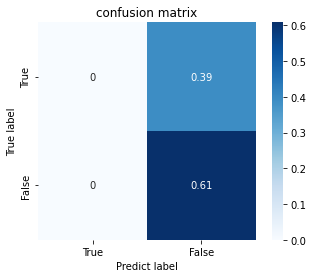

In [29]:
y_base = pd.Series([False for i in range(y_test.shape[0])], index=y_test.index)
display(y_test.value_counts())
show_confusion_matrix(y_test, y_base)

# 様々な機械学習手法の比較

様々な機械学習手法を用いて2値分類を行う。  
簡単に精度を見るため、再現性は担保されていない（引数にrandom_stateを要求しないclfもあるため）ので、必要に応じて再度モデルを構築すること。  
また、パラメータはデフォルト値を使用している。  
そのためパラメータ次第では結果が向上、下降しうる（決定木のf1など）。  

In [30]:
bcm_names = [
    "Logistic Regression",
    "Nearest Neighbors",
    "Linear SVM",
    "Polynomial SVM",
    "RBF SVM",
    "Sigmoid SVM",
    "Decision Tree",
    "Random Forest",
    "AdaBoost",
    "Naive Bayes",
    # "Linear Discriminant Analysis", # predictメソッドに対応していない
    "Quadratic Discriminant Analysis",
]

classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(),
    SVC(kernel="linear"),
    SVC(kernel="poly"),
    SVC(kernel="rbf"),
    SVC(kernel="sigmoid"),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GaussianNB(),
    # LDA(),
    QDA(),
]

In [31]:
import warnings


def compare_bcms(
    X: pd.DataFrame(),
    y: pd.Series(),
    bcm_names: list = bcm_names,
    classifiers: list = classifiers,
    sort_column_name: str = "f1_test",
    average_time: int = 20,
    test_size: float = 0.25,
    over_sampling=None,
    plot_columns: list = ["AGE_AT_DIAGNOSIS", "TMB_NONSYNONYMOUS"],
):
    warnings.filterwarnings("ignore")  # lrで警告が出て視認性が悪いので、いったん非表示
    result = []

    for name, clf in zip(bcm_names, classifiers):  # 指定した複数の分類機を順番に呼び出す
        # 乱数の影響を均した平均を取りたいので、SEEDは保留。乱数に依存しない精度を見るので再現性は'ここでは'担保しない。
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size
        )  # 訓練データ・テストデータの生成
        if over_sampling:
            X_train, y_train = sm.fit_resample(X_train, y_train)
        for _ in tqdm(range(average_time)):  # average_time 回繰り返し、指標の平均を見る
            # 訓練のスコア
            clf.fit(X_train, y_train)  # 学習
            y_pred_train = clf.predict(X_train)
            acc_train = accuracy_score(y_train, y_pred_train)
            f1_train = f1_score(y_train, y_pred_train)
            # 　予測値のスコア
            y_pred = clf.predict(X_test)
            acc_test = accuracy_score(y_test, y_pred)  # 正解率（test）の算出
            f1_test = f1_score(y_test, y_pred)
            result.append([name, acc_train, acc_test, f1_train, f1_test])  # 結果の格納

    # 表示設定
    df_result = pd.DataFrame(
        result, columns=["classifier", "acc_train", "acc_test", "f1_train", "f1_test"]
    )
    df_result_mean = (
        df_result.groupby("classifier")
        .mean()
        .sort_values(sort_column_name, ascending=False)
    )
    warnings.filterwarnings("always")
    return df_result_mean

In [32]:
compare_bcms(X=X, y=y, average_time=100)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.05it/s]


,acc_train,acc_test,f1_train,f1_test
classifier,,,,
Naive Bayes,0.427150,0.455319,0.576681,0.608563
Quadratic Discriminant Analysis,0.449893,0.391489,0.601852,0.548896
Decision Tree,1.000000,0.583489,1.000000,0.538660
AdaBoost,0.703625,0.682979,0.582583,0.532915
Logistic Regression,0.683014,0.636170,0.572797,0.473846
Linear SVM,0.681592,0.665957,0.510917,0.464164
Random Forest,1.000000,0.616638,1.000000,0.434908
Nearest Neighbors,0.727079,0.589362,0.633588,0.427300
Sigmoid SVM,0.533049,0.527660,0.431169,0.393443


デフォルト値のままではf1スコアが出ない  
→全て負事例（0: 5年後も生存）で予測しているケースが多い（多少は正事例（1: 5年以内に死亡）としているケースもあるが）

# ロジスティック回帰モデル

発生確率を予測する手法  
予測結果が0~1の間を取る  

In [33]:
clf_lr = LogisticRegression()
clf_lr.fit(X_train, y_train)
# 訓練データでの正答率
clf_lr.score(X_train, y_train)

C:\Users\uga\anaconda3\envs\breast_cancer_analytics\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6830135039090263

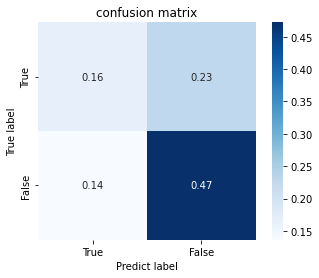

In [34]:
y_pred_lr = clf_lr.predict(X_test)
show_confusion_matrix(y_test, y_pred_lr)

# 決定木モデル
 
sklearnの決定木モデルを作成する。  
精度の高いモデルを選びたいので、葉の数を2~50まで変動させ、accuracyを見る

## 決定木モデルの構築・検証

決定木モデルを構築し、検証していく。  
パラメータを操作するため、forループで回し、最もスコアの高いものを見ていく。

In [35]:
import warnings

warnings.filterwarnings("ignore")  # lrで警告が出て視認性が悪いので、いったん非表示

accuracies_tree = {}
precisions_tree = {}
recalls_tree = {}
f1_scores_tree = {}

for nodes_num in range(2, 50):
    clf_tree = DecisionTreeClassifier(max_leaf_nodes=nodes_num, random_state=SEED)
    clf_tree = clf_tree.fit(X_train, y_train)

    y_pred_tree = clf_tree.predict(X_test)

    accuracies_tree[nodes_num] = accuracy_score(y_test, y_pred_tree)
    precisions_tree[nodes_num] = precision_score(y_test, y_pred_tree)
    recalls_tree[nodes_num] = recall_score(y_test, y_pred_tree)
    f1_scores_tree[nodes_num] = f1_score(y_test, y_pred_tree)

    print("nodes_num: ", nodes_num)
    show_scores(y_test, y_pred_tree)
    print("----------" * 10)

warnings.filterwarnings("always")

nodes_num:  2
accuracy:  0.6340425531914894
precision:  0.54
recall:  0.44021739130434784
f1 score:  0.48502994011976047
----------------------------------------------------------------------------------------------------
nodes_num:  3
accuracy:  0.6340425531914894
precision:  0.54
recall:  0.44021739130434784
f1 score:  0.48502994011976047
----------------------------------------------------------------------------------------------------
nodes_num:  4
accuracy:  0.6340425531914894
precision:  0.54
recall:  0.44021739130434784
f1 score:  0.48502994011976047
----------------------------------------------------------------------------------------------------
nodes_num:  5
accuracy:  0.6340425531914894
precision:  0.54
recall:  0.44021739130434784
f1 score:  0.48502994011976047
----------------------------------------------------------------------------------------------------
nodes_num:  6
accuracy:  0.6361702127659574
precision:  0.5822784810126582
recall:  0.25
f1 score:  0.3498098859

'max nodes_num'

9

9

30

30

accuracy:  0.625531914893617
precision:  0.5198019801980198
recall:  0.5706521739130435
f1_score:  0.544041450777202


Text(0, 0.5, 'score')

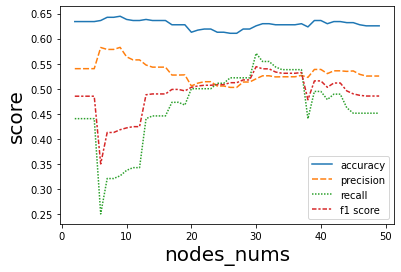

In [36]:
# 各スコアのプロット
display(
    "max nodes_num",
    max(accuracies_tree, key=accuracies_tree.get),
    max(precisions_tree, key=precisions_tree.get),
    max(recalls_tree, key=recalls_tree.get),
    max(f1_scores_tree, key=f1_scores_tree.get),
)

# f1_scoreが最も高いモデルのスコア
print(
    "accuracy: ",
    accuracies_tree[max(f1_scores_tree, key=f1_scores_tree.get)],
)
print(
    "precision: ",
    precisions_tree[max(f1_scores_tree, key=f1_scores_tree.get)],
)
print(
    "recall: ",
    recalls_tree[max(f1_scores_tree, key=f1_scores_tree.get)],
)
print(
    "f1_score: ",
    f1_scores_tree[max(f1_scores_tree, key=f1_scores_tree.get)],
)

df_score_tree = pd.DataFrame(
    [accuracies_tree, precisions_tree, recalls_tree, f1_scores_tree],
    index=["accuracy", "precision", "recall", "f1 score"],
    columns=accuracies_tree.keys(),
).T
p = sns.lineplot(data=df_score_tree)
p.set_xlabel("nodes_nums", fontsize=20)
p.set_ylabel("score", fontsize=20)

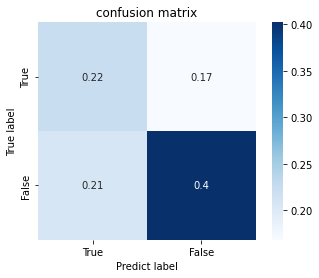

In [37]:
clf_tree = DecisionTreeClassifier(
    max_leaf_nodes=max(f1_scores_tree, key=f1_scores_tree.get),
    random_state=config.SEED,
)
clf_tree = clf_tree.fit(X_train, y_train)
y_pred_tree = clf_tree.predict(X_test)
show_confusion_matrix(y_test, y_pred_tree)

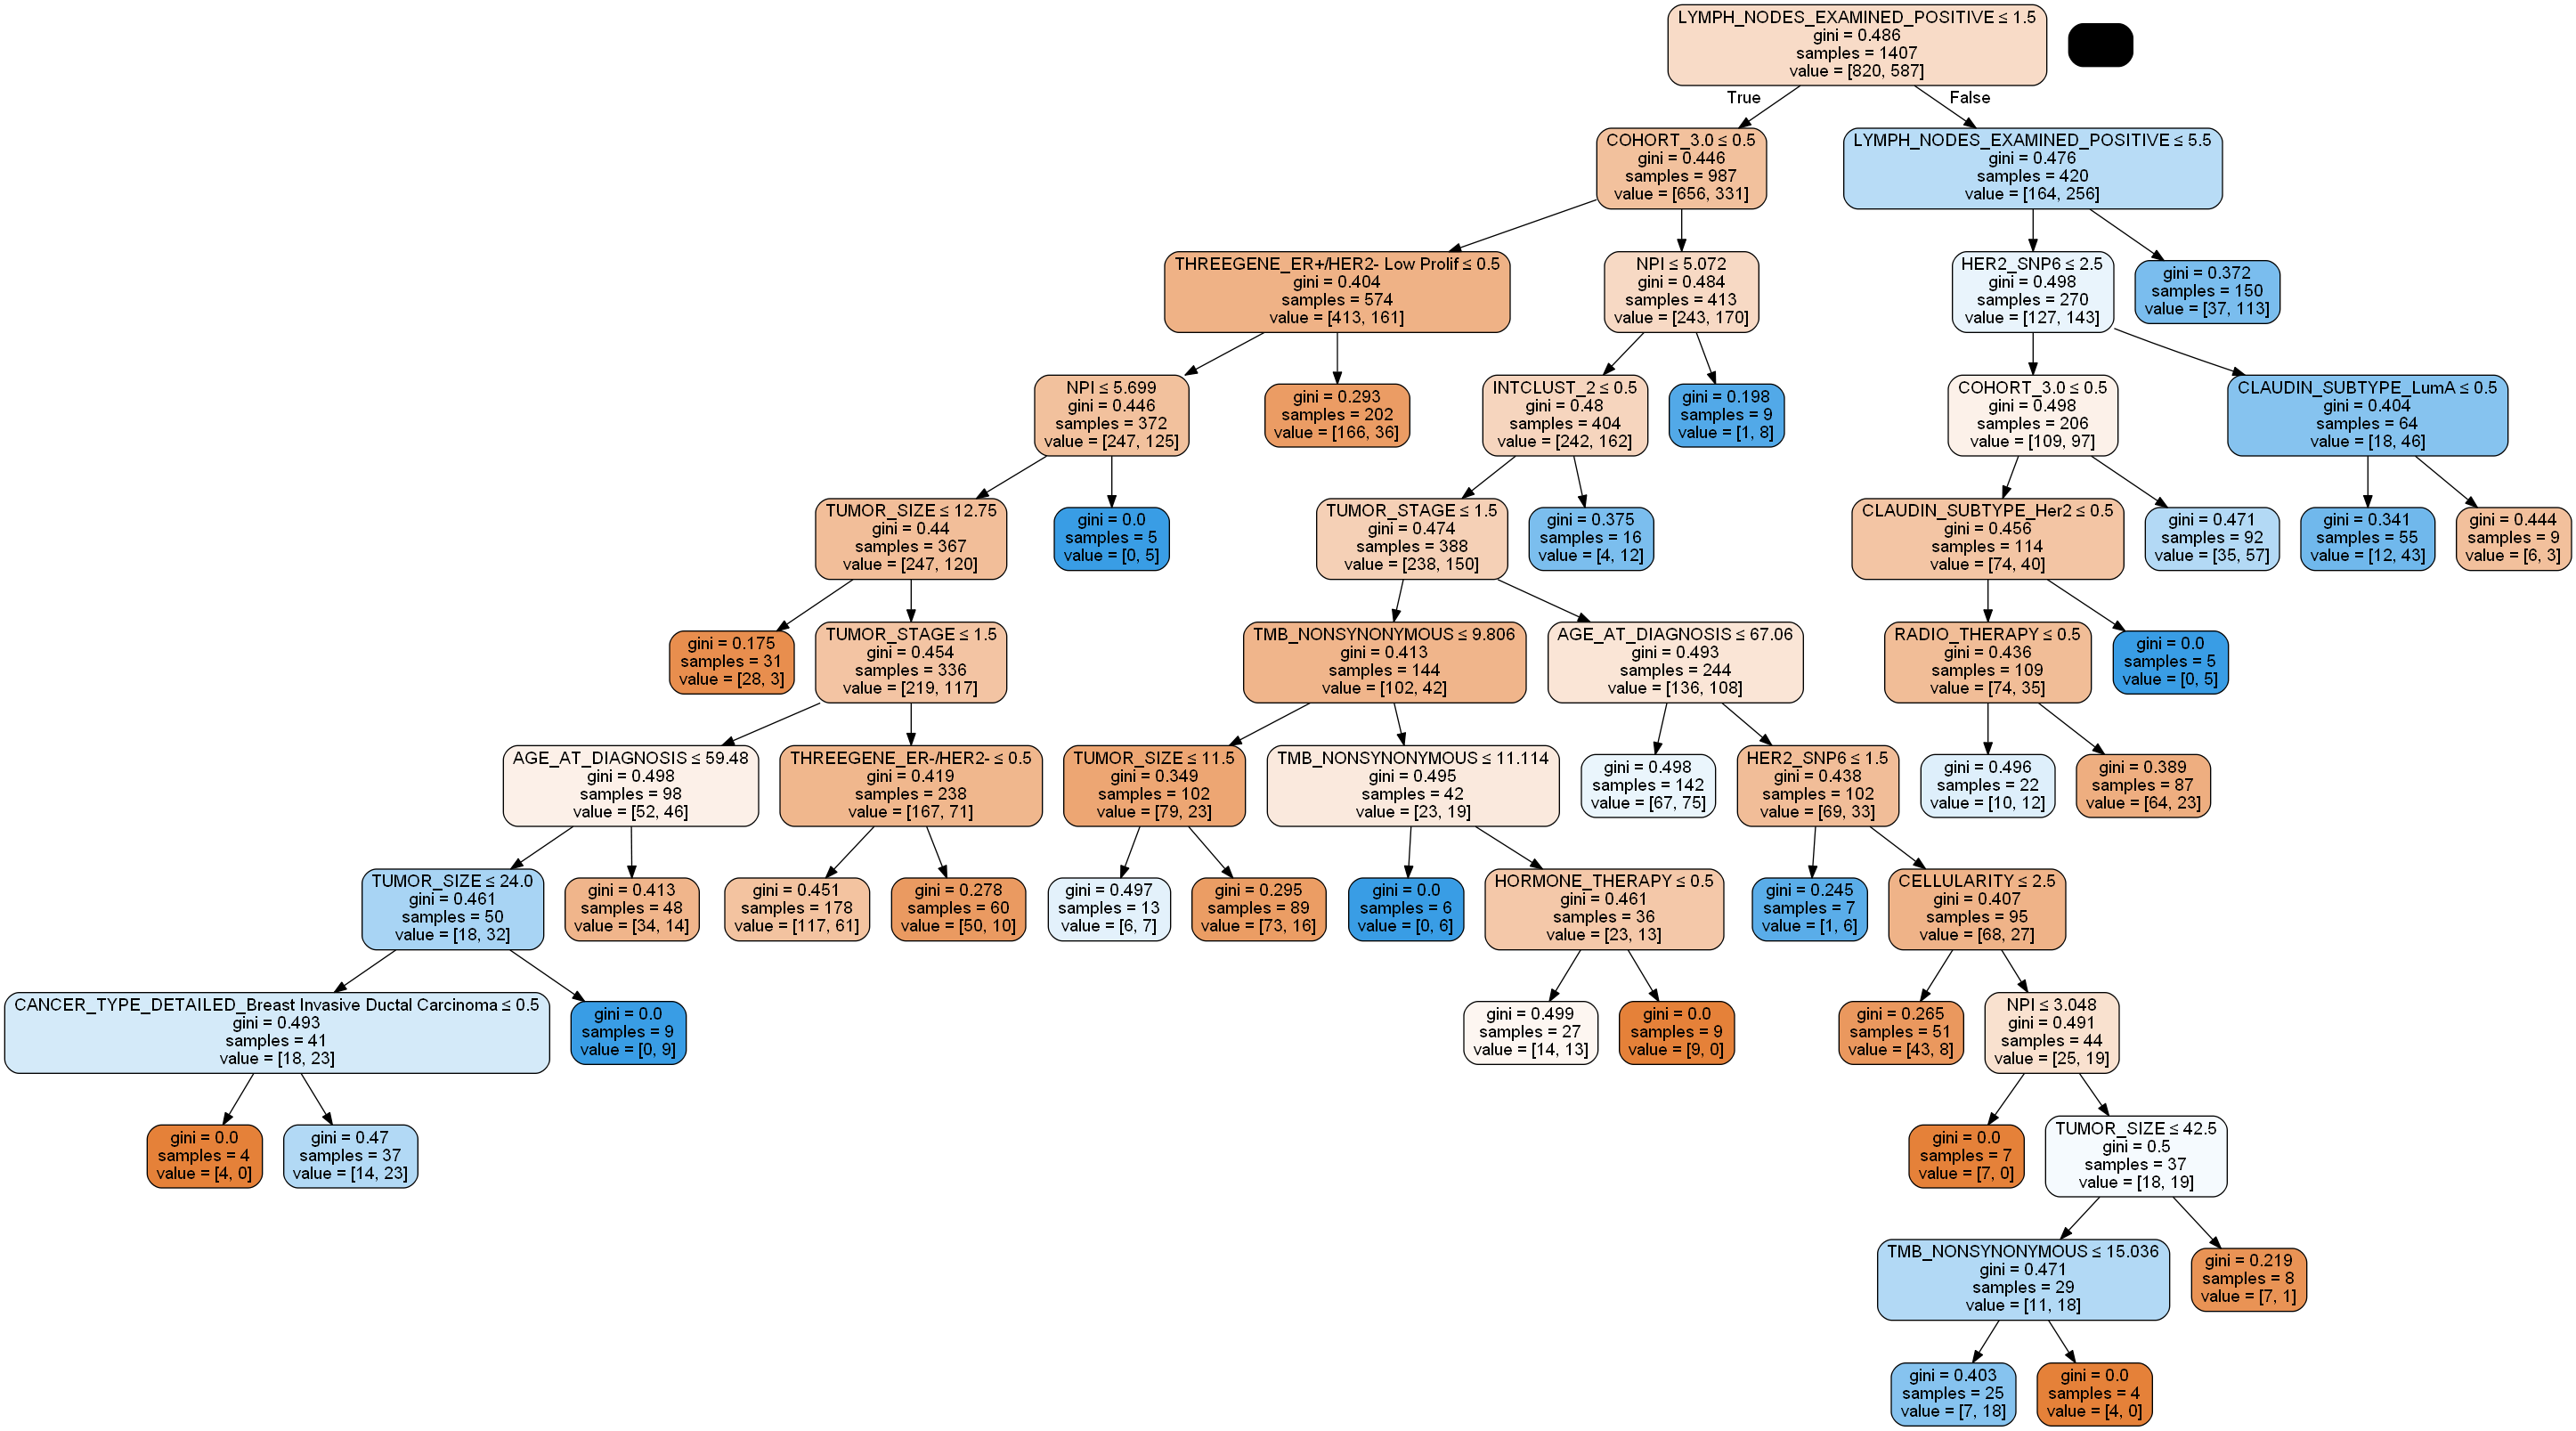

In [38]:
dot_data = StringIO()  # dotファイル情報の格納先
export_graphviz(
    clf_tree,
    out_file=dot_data,
    feature_names=X.columns,
    # class_names= y.unique(),
    filled=True,
    rounded=True,
    special_characters=True,
)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())
# graph.write_png(config.TREE_DIR + "/3.0.0-importance_dt.png")